In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
path_to_file = tf.keras.utils.get_file(fname = 'auto-mpg', origin = url)

In [3]:
column_names = ['mpg', 'cylinders', 'displacement', 'HP', 'weight', 'acceleration', 'modelyear', 'origin']

df = pd.read_csv(path_to_file, 
            sep=" ", 
            comment="\t", 
            names=column_names,
            na_values = "?",
            skipinitialspace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(3)

,mpg,cylinders,displacement,HP,weight,acceleration,modelyear,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


In [4]:
df = pd.get_dummies(df, columns=["origin"])
# we also remove one of them so to keep as reference and avoid multicollinearity
df.drop(columns=["origin_1"], inplace=True)

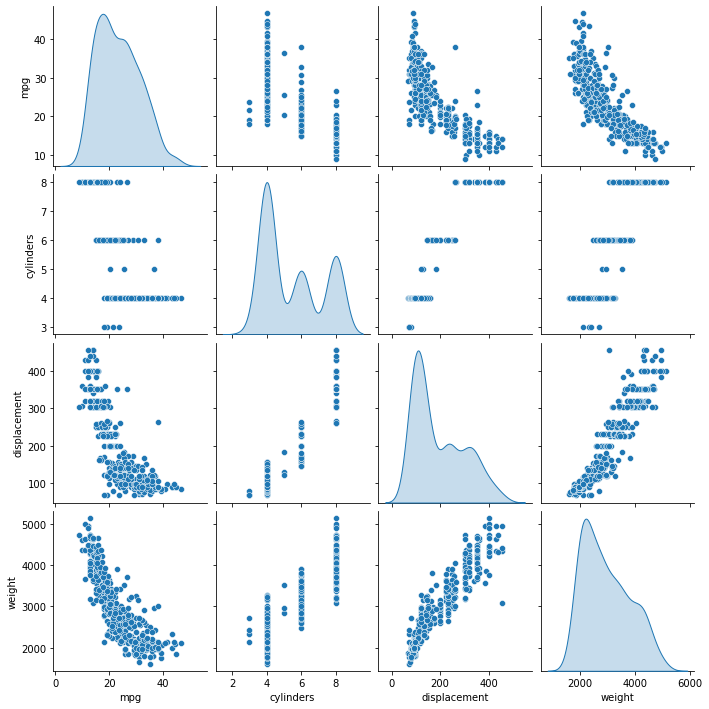

In [5]:
sns.pairplot(df[['mpg', 'cylinders', 'displacement', 'weight']], diag_kind='kde')

In [6]:
# Since our dataset is in the form of a Pandas DataFrame object, we can use sample attribute. 
# We keep the 80% of the observations for training and 20% for testing.

train = df.sample( frac=0.8, random_state = 42)
train_x = train.drop(columns=['mpg'])
train_y = train['mpg']

test = df.drop(train.index)
test_x = test.drop(columns=['mpg'])
test_y = test['mpg']

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler

scaler = make_pipeline(MinMaxScaler(), Normalizer())

train_scal = scaler.fit_transform(train_x)
test_scal = scaler.fit_transform(test_x)

In [9]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [10]:
class MpgModel(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = [input_shape]
        self.layer_1 = Dense(8, activation= tf.nn.relu, input_shape=[input_shape])
        self.layer_2 = Dense(32, activation= tf.nn.relu)
        self.layer_3 = Dense(16, activation= tf.nn.relu)
        self.out = Dense(1)

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.out(x)
        return x

    def build_graph(self):
        # for creating nice plot with subclass functionality
        x = Input(shape=(self.input_dim))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

model_subclass = MpgModel(input_shape= train_scal.shape[1])

model_subclass.build(train_scal.shape)
model_subclass.summary()

Model: "mpg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  72        
                                                                 
 dense_1 (Dense)             multiple                  288       
                                                                 
 dense_2 (Dense)             multiple                  528       
                                                                 
 dense_3 (Dense)             multiple                  17        
                                                                 
Total params: 905
Trainable params: 905
Non-trainable params: 0
_________________________________________________________________


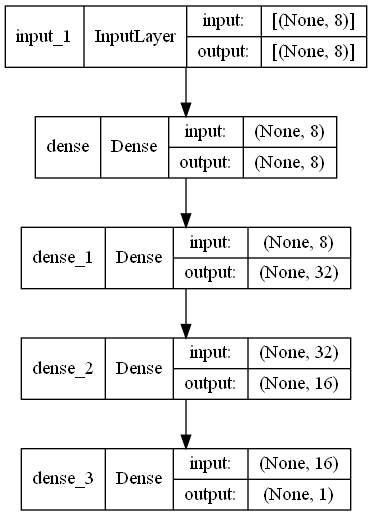

In [11]:
tf.keras.utils.plot_model(
    model_subclass.build_graph(),                      
    show_shapes=True, 
    show_layer_names=True,  
    expand_nested=False                       
)

In [12]:
# Equivalently

# model = Sequential()
# model.add(Dense( 8, activation=tf.nn.relu, input_shape= [train_scal.shape[1]]))
# model.add(Dense(32,activation=tf.nn.relu))
# model.add(Dense(16,activation=tf.nn.relu))
# model.add(Dense(1))

# tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model_subclass.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MSE,
                       tf.keras.metrics.MAE]
            )

#With the following lines of code, we will set an early stopper if we do not see a valuable improvement for 50 epochs
early_stop=tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=50)

In [14]:
# Fitting the Model and Saving the Callback Histories
history = model_subclass.fit(
    x=train_scal,
    y=train_y,
    epochs=1000,
    validation_split = 0.1,
    verbose=0,
    callbacks=[
        early_stop,
        tfdocs.modeling.EpochDots()
        ])


Epoch: 0, loss:600.4393,  mean_absolute_error:23.1969,  mean_squared_error:600.4393,  val_loss:526.5597,  val_mean_absolute_error:21.6217,  val_mean_squared_error:526.5597,  
....................................................................................................
Epoch: 100, loss:10.9053,  mean_absolute_error:2.4732,  mean_squared_error:10.9053,  val_loss:5.8311,  val_mean_absolute_error:1.8533,  val_mean_squared_error:5.8311,  
....................................................................................................
Epoch: 200, loss:9.0171,  mean_absolute_error:2.2498,  mean_squared_error:9.0171,  val_loss:4.5864,  val_mean_absolute_error:1.6337,  val_mean_squared_error:4.5864,  
....................................................................................................
Epoch: 300, loss:8.3252,  mean_absolute_error:2.1523,  mean_squared_error:8.3252,  val_loss:4.4479,  val_mean_absolute_error:1.5473,  val_mean_squared_error:4.4479,  
..................

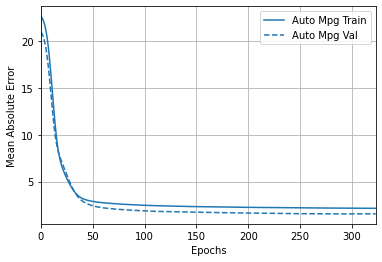

In [15]:
# Evaluating with TensforFlow Docs
plot_obj = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plot_obj.plot({'Auto MPG': history}, metric = "mean_absolute_error")

In [18]:
## On test Set
loss, mae, mse = model_subclass.evaluate(test_scal,
                                test_y,
                                verbose=2)

3/3 - 0s - loss: 8.1778 - mean_squared_error: 8.1778 - mean_absolute_error: 2.2282 - 154ms/epoch - 51ms/step


In [23]:
test_preds = model_subclass.predict(test_scal)
test_preds.flatten()[0:10]

array([14.151544 , 15.232484 , 22.289228 , 21.558172 , 16.079042 ,
       12.7245245, 19.66971  , 22.93437  , 27.216566 , 27.623829 ],
      dtype=float32)

In [38]:
new_car = pd.DataFrame([[8, #cylinders
                        307.0, #displacement
                        130.0, #HP
                        5504.0, #weight
                        12.0, #acceleration
                        70, #modelyear
                        1 #origin
                        ]], columns=column_names[1:])

new_car

,cylinders,displacement,HP,weight,acceleration,modelyear,origin
0,8,307.0,130.0,5504.0,12.0,70,1


In [50]:
new_values_have_to_deal_with_one_hot_encoder = [[8,307,130,5503,12,70,0,0]]
model_subclass.predict(scaler.fit_transform(new_values_have_to_deal_with_one_hot_encoder)).flatten()

array([14.140769], dtype=float32)